# Plot subhalos

In [1]:
import sys, os
sys.path.append('../')

import logging
import numpy as np
import matplotlib.pyplot as plt
import astropy
%matplotlib inline

from simulation.wrapper import augmented_data
from simulation.units import M_s
import paper_settings

logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

## Settings

In [2]:
n_cols = 4
n_rows = 2

## Make data

In [3]:
theta, _, imgs, _, _, _,_, sub_latents, global_latents = augmented_data(
    f_sub=0.05, beta=-1.9, n_images=n_cols*n_rows - 1, mine_gold=False,
    draw_alignment=True, draw_host_mass=True, draw_host_redshift=True
)

17:20 simulation.wrapper   INFO    Simulating image 1 / 7
17:20 simulation.wrapper   INFO    Simulating image 2 / 7
17:20 simulation.wrapper   INFO    Simulating image 3 / 7
17:20 simulation.wrapper   INFO    Simulating image 4 / 7
17:20 simulation.wrapper   INFO    Simulating image 5 / 7
17:20 simulation.wrapper   INFO    Simulating image 6 / 7
17:20 simulation.wrapper   INFO    Simulating image 7 / 7


## Plot subhalos

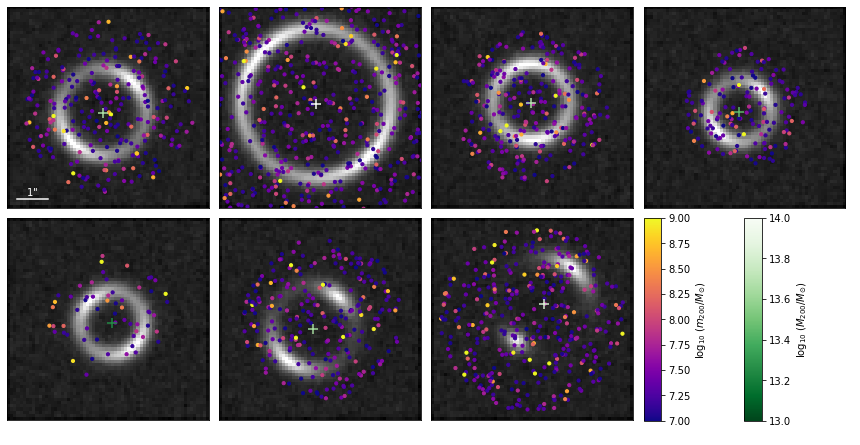

In [7]:
fig, caxes = paper_settings.grid(n_cols, n_rows, n_caxes=2)

for i in range(n_cols*n_rows - 1):
    ax = plt.subplot(n_rows, n_cols, i+1)
    
    im = plt.imshow(
        np.log10(imgs[i]),
        vmin=2.3,
        vmax=3.15,
        cmap='gist_gray',
        extent=(-3.2,3.2,-3.2,3.2),
        origin="lower"
    )
    if i == 0:
        plt.plot([-2.9, -1.9], [-2.9, -2.9], c="white", lw=1.5, ls="-")
        plt.text(-2.4, -2.65, '$1$"', va="center", ha="center", color="white")
    
    sc0 = plt.scatter(
        sub_latents[i][:,1],
        sub_latents[i][:,2],
        s=10.,
        c=np.log10(sub_latents[i][:,0]/M_s),
        cmap="plasma",
        vmin=7.0,
        vmax=9.0,
    )
    if i == 0:
        cbar1 = plt.colorbar(sc0, cax=caxes[0])
        cbar1.set_label(r'$\log_{10} \; (m_{200} / M_{\odot})$')
        
    sc1 = plt.scatter(
        [global_latents[i,4]],
        [global_latents[i,5]],
        s=100.,
        marker="+",
        c=[np.log10(global_latents[i,0]/M_s)],
        cmap="Greens_r",
        vmin=13.0,
        vmax=14.0,
    )
    if i == 0:
        cbar2 = plt.colorbar(sc1, cax=caxes[1])
        cbar2.set_label(r'$\log_{10} \; (M_{200} / M_{\odot})$')
    
    plt.xlim(-3.2,3.2)
    plt.ylim(-3.2,3.2)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.savefig("../figures/subhalos.pdf")